In [359]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import argmax
# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

bucket_name = 'marcs-bucket' # <--- change this variable to a unique name for your bucket
s3 = boto3.resource('s3')

    
try:
  urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
  print('Success: downloaded bank_clean.csv.')
except Exception as e:
  print('Data load error: ',e)
#data from UCI 
redwine = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
whitewine= 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

try:
  red_data = pd.read_csv(redwine, sep=';')
  print('Success: Red wine Data loaded into dataframe.')

except Exception as e:
    print('Data load error for Red Wine: ',e)
    
try:
  white_data = pd.read_csv(whitewine, sep=';')
  print('Success: White Wine Data loaded into dataframe.')

except Exception as e:
    print('Data load error for White Wine: ',e)
    


Success - the MySageMakerInstance is in the us-east-2 region. You will use the 825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest container for your SageMaker endpoint.
Success: downloaded bank_clean.csv.
Success: Red wine Data loaded into dataframe.
Success: White Wine Data loaded into dataframe.


In [325]:
print('white wine')
white_data.head()

white wine


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [326]:
print('red wine')
red_data.head()

red wine


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [360]:
#need to add another column to label instance either red or white. 
red_data['wine type'] = 'Red'
white_data['wine type'] = 'White'
#combine the datasets
wine_data = white_data.append(red_data)

wine_data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,White
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,White
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,White
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,White
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,White


In [361]:
#additionally onehot encoding the quality
wine_data["quality"] =wine_data["quality"].astype(int)
wine_data = pd.get_dummies(wine_data, columns=["quality"])
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine type,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,White,0,0,0,1,0,0,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,White,0,0,0,1,0,0,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,White,0,0,0,1,0,0,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,White,0,0,0,1,0,0,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,White,0,0,0,1,0,0,0


In [362]:
#creating onehot encoding for winetype the variable we are using as a predictor
wine_data = pd.get_dummies(wine_data, columns=["wine type"])
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine type_Red,wine type_White
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0,0,0,1,0,0,0,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0,0,0,1,0,0,0,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0,0,0,1,0,0,0,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,0,0,1,0,0,0,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,0,0,1,0,0,0,0,1


In [330]:
#Starting Data exploration
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 1598
Data columns (total 20 columns):
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
wine type_Red           6497 non-null uint8
wine type_White         6497 non-null uint8
quality_3               6497 non-null uint8
quality_4               6497 non-null uint8
quality_5               6497 non-null uint8
quality_6               6497 non-null uint8
quality_7               6497 non-null uint8
quality_8               6497 non-null uint8
quality_9               6497 non-nu

In [331]:
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine type_Red,wine type_White,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,0.246114,0.753886,0.004618,0.033246,0.329075,0.436509,0.166077,0.029706,0.000770
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.430779,0.430779,0.067800,0.179292,0.469913,0.495991,0.372178,0.169788,0.027733
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


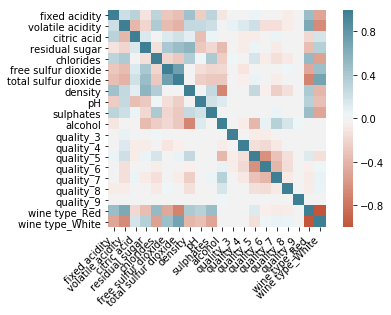

In [363]:
#lets check the correlations via a Heat Map!

corr = wine_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);



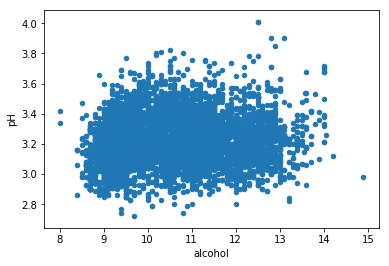

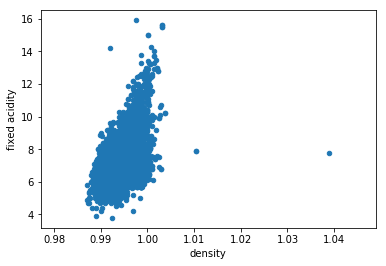

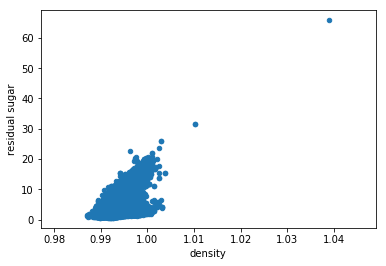

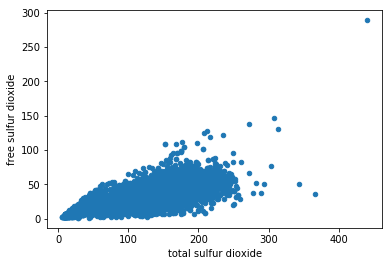

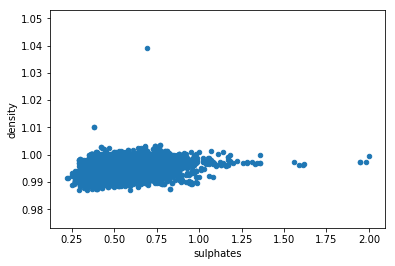

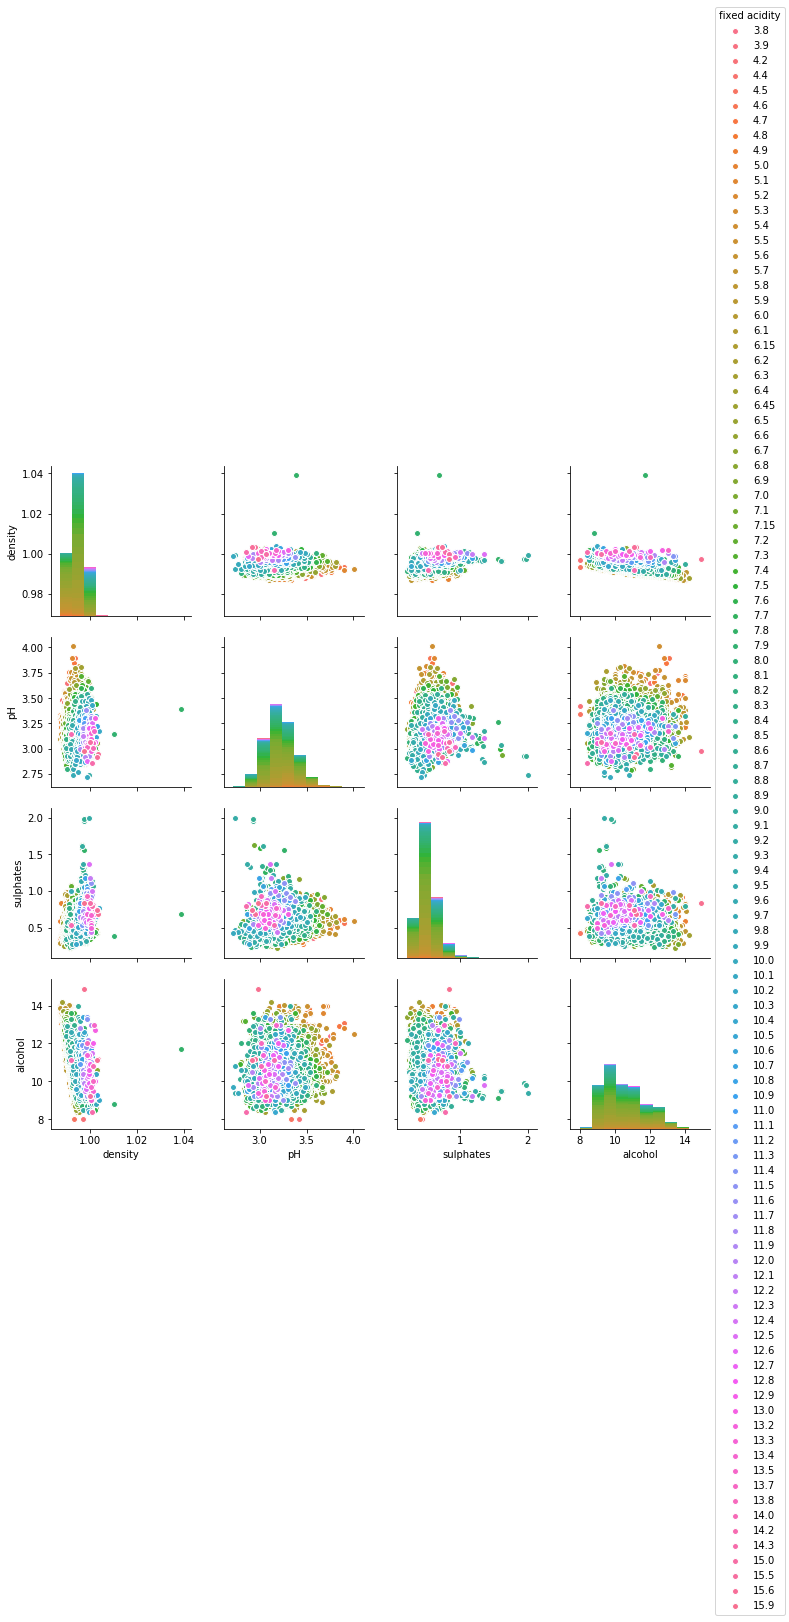

In [342]:
#alcohol and Quality seem interesting 
wine_data.plot.scatter(x='alcohol',y='pH')
wine_data.plot.scatter(x='density',y='fixed acidity')
wine_data.plot.scatter(x='density',y='residual sugar')
wine_data.plot.scatter(x='total sulfur dioxide',y='free sulfur dioxide')
wine_data.plot.scatter(x='sulphates',y='density')


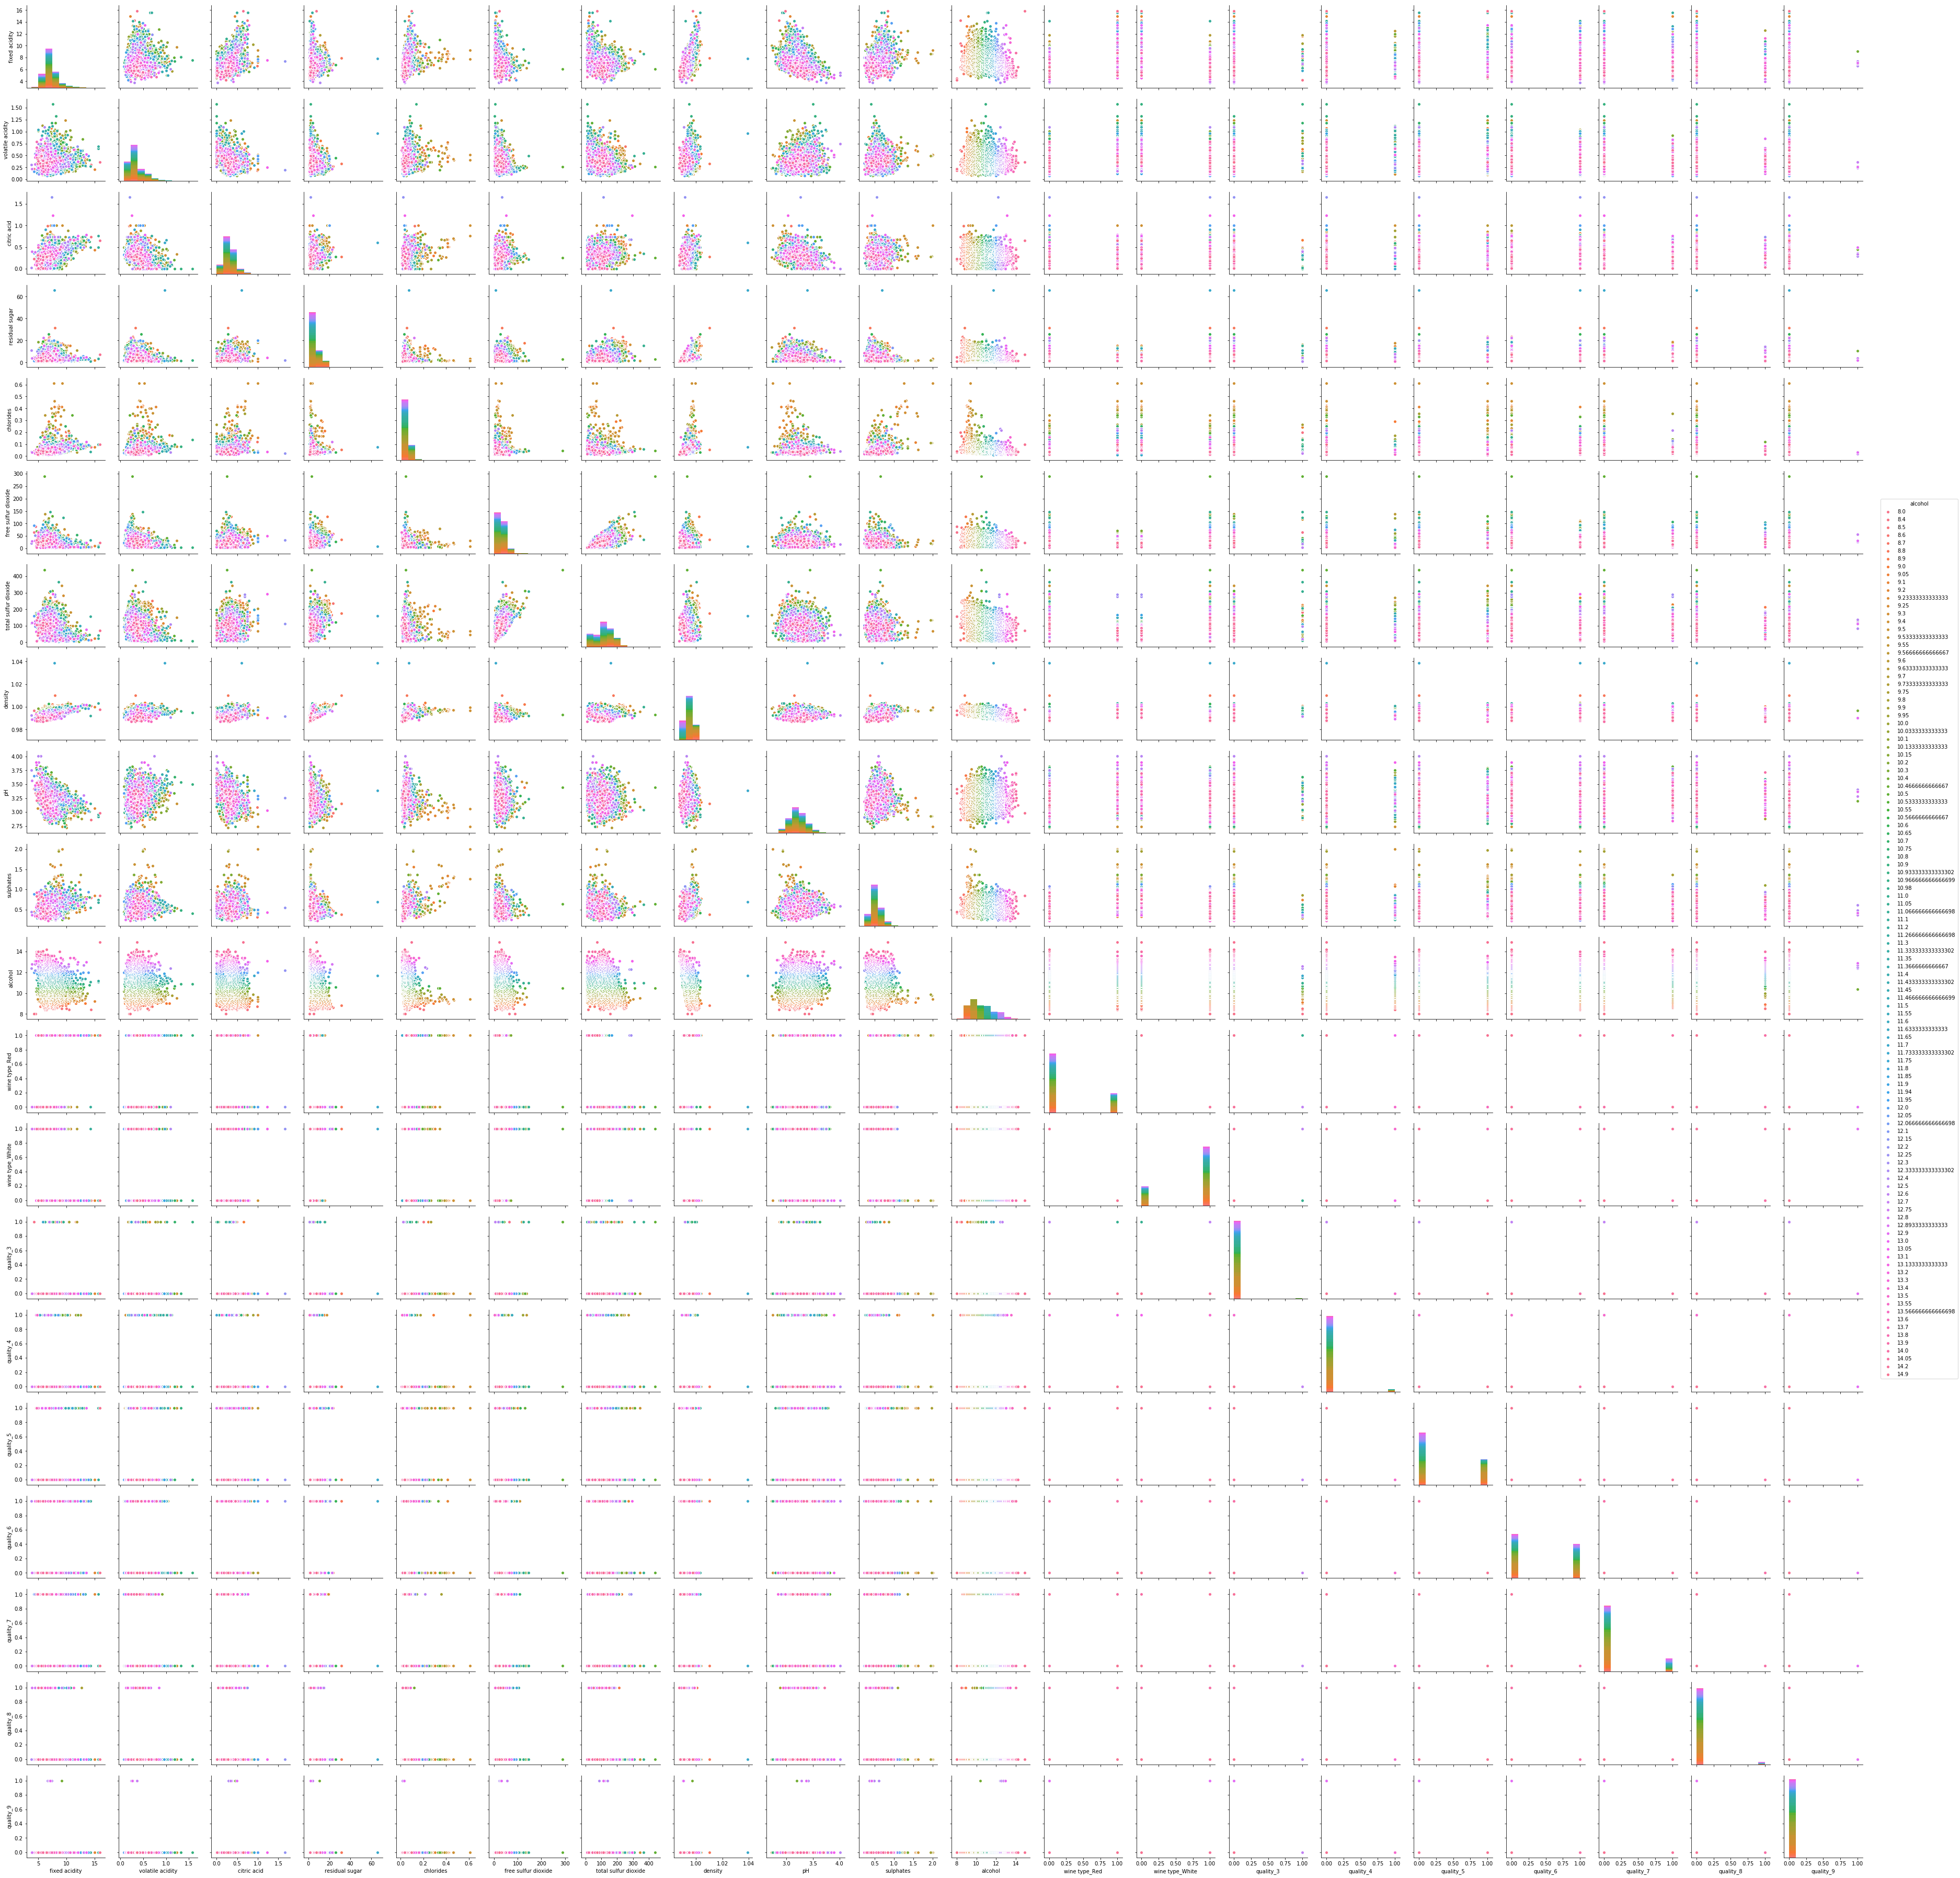

In [343]:
s=sns.pairplot(wine_data, hue="alcohol")
plt.show(s)

In [344]:
#checking for missing data
wine_data.isnull().sum()

#there is no missing data hooray! 

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
wine type_Red           0
wine type_White         0
quality_3               0
quality_4               0
quality_5               0
quality_6               0
quality_7               0
quality_8               0
quality_9               0
dtype: int64

In [391]:
#splitting the Data set:
#getting data ready for kFold
observations = np.array(wine_data.iloc[0:,0:18])
labels = np.array(wine_data.iloc[0:,18:])
print(labels[0])
#prepping for kfold
from sklearn.model_selection import KFold
kfold = KFold(5, True, 333)


[0 1]


In [397]:
from keras import layers, optimizers, regularizers
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential
model = Sequential()
# layer 1
model.add(Dense(30, input_dim=18, activation='relu', name='layer0',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
#layer 2
model.add(Dense(50, name='layer1',bias_initializer='zeros'))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#layer 3
model.add(Dense(100, name='layer2',bias_initializer='zeros'))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#layer 4
model.add(Dense(2, name='layer3',bias_initializer='zeros'))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
model.add(Activation('softmax'))


In [398]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Dense)               (None, 30)                570       
_________________________________________________________________
batch_normalization_61 (Batc (None, 30)                120       
_________________________________________________________________
layer1 (Dense)               (None, 50)                1550      
_________________________________________________________________
batch_normalization_62 (Batc (None, 50)                200       
_________________________________________________________________
activation_46 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 50)                0         
_________________________________________________________________
layer2 (Dense)               (None, 100)               5100      
__________

In [410]:

optimize = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimize, loss = "categorical_crossentropy", metrics = ["categorical_accuracy"])
#model.compile(optimizer = 'adam', loss = "mean_squared_error", metrics = ["mae",'acc'])





In [403]:
def myneuralnet(obs,label,epoch):
    myacc = []
    myloss = []
    for train, test in kfold.split(observations):
        
        obs_train, obs_test = observations[train], observations[test]
        label_train, label_test = labels[train], labels[test]


        model.fit(x = obs_train, y = label_train, epochs = epoch,verbose=1, batch_size = 64,validation_data=(obs_test, label_test))
        preds = model.evaluate(x = obs_test, y = label_test)
       
        #print ("Loss = " + str(preds[0]))
        #print ("Test Accuracy = " + str(preds[1]))
        myloss.append(preds[0])
        myacc.append((preds[1]))

    crossfold_acc = np.average(myacc)
    crossfold_loss = np.average(myloss)
    
    print(crossfold_acc*100, 'is the Cross Fold Accuracy')
    return crossfold_acc , crossfold_loss


In [411]:
myneuralnet(observations,labels,100)

Train on 5197 samples, validate on 1300 samples
Epoch 1/100
5197/5197 [==============================] - 7s 1ms/step - loss: 0.0584 - categorical_accuracy: 0.9865 - val_loss: 0.2084 - val_categorical_accuracy: 0.9354
Epoch 2/100
5197/5197 [==============================] - 0s 92us/step - loss: 0.0582 - categorical_accuracy: 0.9852 - val_loss: 0.0863 - val_categorical_accuracy: 0.9700
Epoch 3/100
5197/5197 [==============================] - 1s 109us/step - loss: 0.0583 - categorical_accuracy: 0.9865 - val_loss: 0.1534 - val_categorical_accuracy: 0.9508
Epoch 4/100
5197/5197 [==============================] - 0s 92us/step - loss: 0.0568 - categorical_accuracy: 0.9865 - val_loss: 0.1533 - val_categorical_accuracy: 0.9508
Epoch 5/100
5197/5197 [==============================] - 0s 96us/step - loss: 0.0554 - categorical_accuracy: 0.9875 - val_loss: 0.0744 - val_categorical_accuracy: 0.9746
Epoch 6/100
5197/5197 [==============================] - 0s 95us/step - loss: 0.0556 - categorical_acc

5197/5197 [==============================] - 0s 95us/step - loss: 0.0490 - categorical_accuracy: 0.9863 - val_loss: 0.1002 - val_categorical_accuracy: 0.9662
Epoch 49/100
5197/5197 [==============================] - 1s 137us/step - loss: 0.0497 - categorical_accuracy: 0.9875 - val_loss: 0.2312 - val_categorical_accuracy: 0.9308
Epoch 50/100
5197/5197 [==============================] - 1s 102us/step - loss: 0.0534 - categorical_accuracy: 0.9854 - val_loss: 0.1465 - val_categorical_accuracy: 0.9631
Epoch 51/100
5197/5197 [==============================] - 1s 99us/step - loss: 0.0563 - categorical_accuracy: 0.9863 - val_loss: 1.5275 - val_categorical_accuracy: 0.5377
Epoch 52/100
5197/5197 [==============================] - 1s 102us/step - loss: 0.0629 - categorical_accuracy: 0.9846 - val_loss: 0.1815 - val_categorical_accuracy: 0.9592
Epoch 53/100
5197/5197 [==============================] - 1s 136us/step - loss: 0.0531 - categorical_accuracy: 0.9883 - val_loss: 0.1739 - val_categorical_

Epoch 96/100
5197/5197 [==============================] - 1s 107us/step - loss: 0.0512 - categorical_accuracy: 0.9869 - val_loss: 0.1753 - val_categorical_accuracy: 0.9469
Epoch 97/100
5197/5197 [==============================] - 1s 115us/step - loss: 0.0477 - categorical_accuracy: 0.9879 - val_loss: 0.1260 - val_categorical_accuracy: 0.9638
Epoch 98/100
5197/5197 [==============================] - 1s 105us/step - loss: 0.0634 - categorical_accuracy: 0.9836 - val_loss: 0.0853 - val_categorical_accuracy: 0.9669
Epoch 99/100
5197/5197 [==============================] - 1s 104us/step - loss: 0.0507 - categorical_accuracy: 0.9883 - val_loss: 0.0390 - val_categorical_accuracy: 0.9900
Epoch 100/100
1300/1300 [==============================] - 0s 141us/step
Train on 5197 samples, validate on 1300 samples
Epoch 1/100
5197/5197 [==============================] - 1s 100us/step - loss: 0.0421 - categorical_accuracy: 0.9904 - val_loss: 0.0622 - val_categorical_accuracy: 0.9808
Epoch 2/100
5197/519

5197/5197 [==============================] - 0s 93us/step - loss: 0.0460 - categorical_accuracy: 0.9875 - val_loss: 0.3580 - val_categorical_accuracy: 0.8992
Epoch 44/100
5197/5197 [==============================] - 0s 94us/step - loss: 0.0484 - categorical_accuracy: 0.9881 - val_loss: 0.0570 - val_categorical_accuracy: 0.9846
Epoch 45/100
5197/5197 [==============================] - 1s 110us/step - loss: 0.0445 - categorical_accuracy: 0.9890 - val_loss: 0.0928 - val_categorical_accuracy: 0.9731
Epoch 46/100
5197/5197 [==============================] - 0s 93us/step - loss: 0.0382 - categorical_accuracy: 0.9906 - val_loss: 0.3624 - val_categorical_accuracy: 0.8654
Epoch 47/100
5197/5197 [==============================] - 0s 93us/step - loss: 0.0427 - categorical_accuracy: 0.9886 - val_loss: 0.5620 - val_categorical_accuracy: 0.8662
Epoch 48/100
5197/5197 [==============================] - 0s 94us/step - loss: 0.0439 - categorical_accuracy: 0.9898 - val_loss: 0.0611 - val_categorical_acc

Epoch 91/100
5197/5197 [==============================] - 0s 91us/step - loss: 0.0413 - categorical_accuracy: 0.9898 - val_loss: 0.1114 - val_categorical_accuracy: 0.9623
Epoch 92/100
5197/5197 [==============================] - 0s 93us/step - loss: 0.0381 - categorical_accuracy: 0.9900 - val_loss: 0.1101 - val_categorical_accuracy: 0.9669
Epoch 93/100
5197/5197 [==============================] - 0s 93us/step - loss: 0.0422 - categorical_accuracy: 0.9890 - val_loss: 0.0908 - val_categorical_accuracy: 0.9723
Epoch 94/100
5197/5197 [==============================] - 0s 91us/step - loss: 0.0390 - categorical_accuracy: 0.9900 - val_loss: 0.1222 - val_categorical_accuracy: 0.9585
Epoch 95/100
5197/5197 [==============================] - 1s 119us/step - loss: 0.0433 - categorical_accuracy: 0.9906 - val_loss: 0.1362 - val_categorical_accuracy: 0.9585
Epoch 96/100
5197/5197 [==============================] - 0s 96us/step - loss: 0.0404 - categorical_accuracy: 0.9888 - val_loss: 1.2788 - val_ca

5198/5198 [==============================] - 1s 145us/step - loss: 0.0532 - categorical_accuracy: 0.9863 - val_loss: 4.9901 - val_categorical_accuracy: 0.2864
Epoch 39/100
5198/5198 [==============================] - 1s 106us/step - loss: 0.1107 - categorical_accuracy: 0.9677 - val_loss: 0.6094 - val_categorical_accuracy: 0.7952
Epoch 40/100
5198/5198 [==============================] - 1s 105us/step - loss: 0.0650 - categorical_accuracy: 0.9808 - val_loss: 0.0530 - val_categorical_accuracy: 0.9892
Epoch 41/100
5198/5198 [==============================] - 1s 108us/step - loss: 0.0556 - categorical_accuracy: 0.9861 - val_loss: 0.1895 - val_categorical_accuracy: 0.9484
Epoch 42/100
5198/5198 [==============================] - 1s 140us/step - loss: 0.0499 - categorical_accuracy: 0.9879 - val_loss: 0.1089 - val_categorical_accuracy: 0.9592
Epoch 43/100
5198/5198 [==============================] - 1s 111us/step - loss: 0.0451 - categorical_accuracy: 0.9886 - val_loss: 0.8755 - val_categorica

Epoch 86/100
5198/5198 [==============================] - 1s 102us/step - loss: 0.0464 - categorical_accuracy: 0.9877 - val_loss: 0.3578 - val_categorical_accuracy: 0.8853
Epoch 87/100
5198/5198 [==============================] - 1s 126us/step - loss: 0.0476 - categorical_accuracy: 0.9861 - val_loss: 3.0190 - val_categorical_accuracy: 0.3664
Epoch 88/100
5198/5198 [==============================] - 1s 103us/step - loss: 0.0498 - categorical_accuracy: 0.9863 - val_loss: 0.0610 - val_categorical_accuracy: 0.9808
Epoch 89/100
5198/5198 [==============================] - 1s 108us/step - loss: 0.0445 - categorical_accuracy: 0.9894 - val_loss: 0.0646 - val_categorical_accuracy: 0.9784
Epoch 90/100
5198/5198 [==============================] - 1s 106us/step - loss: 0.0510 - categorical_accuracy: 0.9881 - val_loss: 0.1246 - val_categorical_accuracy: 0.9530
Epoch 91/100
5198/5198 [==============================] - 1s 127us/step - loss: 0.0483 - categorical_accuracy: 0.9873 - val_loss: 0.1020 - v

5198/5198 [==============================] - 1s 125us/step - loss: 0.0510 - categorical_accuracy: 0.9879 - val_loss: 0.0540 - val_categorical_accuracy: 0.9815
Epoch 34/100
5198/5198 [==============================] - 0s 91us/step - loss: 0.0453 - categorical_accuracy: 0.9890 - val_loss: 0.1886 - val_categorical_accuracy: 0.9269
Epoch 35/100
5198/5198 [==============================] - 0s 91us/step - loss: 0.0518 - categorical_accuracy: 0.9879 - val_loss: 0.0932 - val_categorical_accuracy: 0.9677
Epoch 36/100
5198/5198 [==============================] - 0s 91us/step - loss: 0.0505 - categorical_accuracy: 0.9886 - val_loss: 0.3451 - val_categorical_accuracy: 0.8807
Epoch 37/100
5198/5198 [==============================] - 1s 114us/step - loss: 0.0525 - categorical_accuracy: 0.9873 - val_loss: 0.1294 - val_categorical_accuracy: 0.9607
Epoch 38/100
5198/5198 [==============================] - 0s 95us/step - loss: 0.0477 - categorical_accuracy: 0.9888 - val_loss: 0.1240 - val_categorical_ac

Epoch 81/100
5198/5198 [==============================] - 1s 193us/step - loss: 0.0480 - categorical_accuracy: 0.9888 - val_loss: 0.0725 - val_categorical_accuracy: 0.9823
Epoch 82/100
5198/5198 [==============================] - 1s 181us/step - loss: 0.0510 - categorical_accuracy: 0.9854 - val_loss: 0.0541 - val_categorical_accuracy: 0.9854
Epoch 83/100
5198/5198 [==============================] - 1s 206us/step - loss: 0.0520 - categorical_accuracy: 0.9881 - val_loss: 0.0625 - val_categorical_accuracy: 0.9831
Epoch 84/100
5198/5198 [==============================] - 1s 155us/step - loss: 0.0499 - categorical_accuracy: 0.9885 - val_loss: 0.0632 - val_categorical_accuracy: 0.9892
Epoch 85/100
5198/5198 [==============================] - 1s 190us/step - loss: 0.0478 - categorical_accuracy: 0.9890 - val_loss: 0.1417 - val_categorical_accuracy: 0.9600
Epoch 86/100
5198/5198 [==============================] - 1s 101us/step - loss: 0.0497 - categorical_accuracy: 0.9860 - val_loss: 0.0623 - v

Epoch 28/100
5198/5198 [==============================] - 1s 120us/step - loss: 0.0463 - categorical_accuracy: 0.9885 - val_loss: 0.0602 - val_categorical_accuracy: 0.9831
Epoch 29/100
5198/5198 [==============================] - 0s 95us/step - loss: 0.0508 - categorical_accuracy: 0.9854 - val_loss: 0.1923 - val_categorical_accuracy: 0.9207
Epoch 30/100
5198/5198 [==============================] - 0s 96us/step - loss: 0.0497 - categorical_accuracy: 0.9858 - val_loss: 0.0827 - val_categorical_accuracy: 0.9754
Epoch 31/100
5198/5198 [==============================] - 0s 92us/step - loss: 0.0472 - categorical_accuracy: 0.9879 - val_loss: 0.0519 - val_categorical_accuracy: 0.9877
Epoch 32/100
5198/5198 [==============================] - 1s 118us/step - loss: 0.0472 - categorical_accuracy: 0.9894 - val_loss: 0.1456 - val_categorical_accuracy: 0.9607
Epoch 33/100
5198/5198 [==============================] - 1s 98us/step - loss: 0.0481 - categorical_accuracy: 0.9894 - val_loss: 0.3776 - val_c

Epoch 76/100
5198/5198 [==============================] - 0s 91us/step - loss: 0.0426 - categorical_accuracy: 0.9885 - val_loss: 2.1307 - val_categorical_accuracy: 0.4172
Epoch 77/100
5198/5198 [==============================] - 0s 91us/step - loss: 0.0470 - categorical_accuracy: 0.9885 - val_loss: 0.1588 - val_categorical_accuracy: 0.9577
Epoch 78/100
5198/5198 [==============================] - 1s 112us/step - loss: 0.0444 - categorical_accuracy: 0.9896 - val_loss: 0.1823 - val_categorical_accuracy: 0.9500
Epoch 79/100
5198/5198 [==============================] - 0s 91us/step - loss: 0.0469 - categorical_accuracy: 0.9883 - val_loss: 0.0997 - val_categorical_accuracy: 0.9661
Epoch 80/100
5198/5198 [==============================] - 0s 90us/step - loss: 0.0447 - categorical_accuracy: 0.9883 - val_loss: 0.1095 - val_categorical_accuracy: 0.9654
Epoch 81/100
5198/5198 [==============================] - 0s 91us/step - loss: 0.0416 - categorical_accuracy: 0.9892 - val_loss: 0.0771 - val_ca

(0.9629022324865281, 0.11944409545074612)